# How does the set of nodes with the top K temp PR score changes?

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [51]:
%matplotlib inline

### Utilities

In [6]:
# gives an array from data
def get_data(filepath, nrows = None):
    edges_arr = np.loadtxt(filepath, delimiter=' ', dtype='i')
    if nrows != None:
        return edges_arr[:nrows,:]
    else:
        return edges_arr

In [7]:
# gives a static, weighted, directed graph from the array
# weights: the number of interactions
def get_graph_from_arr(arr):
    G = nx.DiGraph()
    for i in range(len(arr)):
        edge = arr[i,:]
        if G.has_edge(edge[1], edge[2]):
            G[edge[1]][edge[2]]['weight'] += 1.0
        else:
            G.add_edge(edge[1], edge[2], weight = 1.0)
    return G

### Measurement

In [8]:
filepath = '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv'
arr = get_data(filepath)
G = get_graph_from_arr(arr)
nodes = G.nodes()

Több delta értékre is futtatjuk, nézzük hogyan változik az NDCG átlaga

In [69]:
# columns: node, simple indegree, indegree with damping factor, temporal pagerank, active mass (for temp pr), static pagerank
centrality_values = np.outer(nodes, [1,0.0,0.0,0.0])
nodes_array = np.asarray(nodes)
node_index_map = dict(zip(nodes_array,range(len(nodes_array))))
centrality_values_old = np.copy(centrality_values)

#delta = 1000
topK = 100
delta_values = [1000,2000,5000,10000,20000,40000]
NDCG_averages = []

# indegree damping factor
#damping_factor = 0.9

# temporal pagerank jumping and transition probability
alpha = 0.85
beta = 0.001

for delta in delta_values:
    
    set_old = {}
    set_new = {}
    changes = []
    unique = []
    NDCG = []
    
    for i in range(len(arr)):
        edge = arr[i,:]    
        # get the row index of the source and target node
        edge_target_index = node_index_map[edge[2]]
        edge_source_index = node_index_map[edge[1]]

        # indegree with damping factor
#        centrality_values[:,2] *= damping_factor      <--------------- ez "rontotta el" eddig (2-es oszlop nem lett átírva)
#        centrality_values[edge_target_index,1] +=1

        # temporal pagerank
        centrality_values[edge_source_index,2] += 1-alpha
        centrality_values[edge_source_index,3] += 1-alpha
        centrality_values[edge_target_index,2] += centrality_values[edge_source_index,3]*alpha
        centrality_values[edge_target_index,3] += centrality_values[edge_source_index,3]*(1-beta)*alpha
        centrality_values[edge_source_index,3] *= beta

        # computing the number of changes in the toplist
        if i % delta == 0 or i==len(arr)-1:

            set_old = set_new
            centrality_values_sorted = centrality_values[centrality_values[:,2].argsort()[::-1]][:topK,:]

            set_new = set(centrality_values_sorted[:,0].flat)

            unique.append(len(np.unique(centrality_values_sorted[:,2])))

            diff = len(set_new.difference(set_old))
            changes.append(diff)

            # mostani csúcsok score-jai
            actual_scores = dict(zip(centrality_values[:,0], centrality_values[:,2]))

            DCG = 0
            IDCG = 0
            for j in range(topK):
                DCG += actual_scores[centrality_values_old[j,0]] / math.log2(j+2)
                IDCG += centrality_values_sorted[j,2] / math.log2(j+2)

            NDCG.append(DCG / IDCG)
            # aktualizálom a régi értékeket
            centrality_values_old = np.copy(centrality_values_sorted)

#            print("%i. interval finished!" % i)
    
    NDCG_averages.append(np.mean(NDCG[1:]))
    print("for delta = %i:" % delta, NDCG)
print("Done")

for delta = 1000: [0.0, 0.057838216243977364, 0.84939557314744163, 0.92005151710328548, 0.95552988608801992, 0.89260830813570124, 0.96733680171454328, 0.99109506609945008, 0.96557105200337023, 0.98576139218675918, 0.98910232850938962, 0.98815884915359997, 0.98266649107748683, 0.98792905844028889, 0.97623465423289835, 0.99684783586331172, 0.99750096763598062, 0.99720446503803717, 0.97913416279396825, 0.99366432800841675, 0.98618010272438816, 0.99325234876260471, 0.99366360993965697, 0.99968449923667124, 0.99801864617430114, 0.99767853619274471, 0.9923694109468828, 0.99750097971305141, 0.99538436091598104, 0.99078654146225587, 0.99666198768493286, 0.99568786232609596, 0.99127305650093855, 0.9995515283350187, 0.98841183275924294, 0.99439221307739667, 0.97556314823389034, 0.99475905234265261, 0.99856609886126413, 0.99383938813262518, 0.99866131735050334, 0.99959934880225787, 0.9938987372984347, 0.99827630675378975, 0.99918371569260989, 0.99897464236422628, 0.99947890417106611, 0.9997801408

Ezekről grafikon, max 40ezer
1000, 2000, 5000, 10000, 20000, 40000

In [70]:
NDCG_averages

[0.98948061652475106,
 0.99919421120252405,
 0.99916583725130315,
 0.99916698122915426,
 0.9991424257105499,
 0.99910241573964953]

In [66]:
changes

[100, 3, 1, 0, 4, 2]

In [67]:
unique

[100, 100, 100, 100, 100, 100]

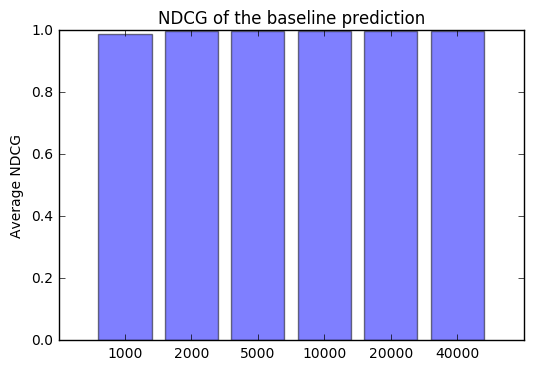

In [68]:
deltas = delta_values
y_pos = np.arange(len(deltas))
values = NDCG_averages
 
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, deltas)
plt.ylabel('Average NDCG')
plt.title('NDCG of the baseline prediction')